## Tehtävä: Oppimisprojekti 2: Kuvantunnistus omilla kuvilla

Tämän projektin tavoitteena on suunnitella ja toteuttaa kuvantunnistusjärjestelmä käyttäen itse otettuja kuvia. Projekti toteutetaan vaiheittain hyödyntäen eri konvoluutioneuroverkkomenetelmiä yksinkertaisesta edistyneempään.

#### Datankäsittely

In [17]:
import os
from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory

image_folder = '../week2_photodata/'

train_dataset = image_dataset_from_directory(
    image_folder+'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    batch_size=4
)

test_dataset = image_dataset_from_directory(
    image_folder+'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100)
)

validation_dataset = image_dataset_from_directory(
    image_folder+'validation',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    shuffle=True
)
   
for images, labels in test_dataset:
    print(f"Batch of images shape: {images.shape}")

Found 180 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Batch of images shape: (32, 100, 100, 3)
Batch of images shape: (8, 100, 100, 3)


In [18]:
from keras import Sequential
from keras import layers
from keras import regularizers
from keras.optimizers import Adam

model = Sequential([
    layers.Input(shape=(100, 100, 3)),
    layers.Rescaling(scale=1./255),

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(4, activation='softmax')
])


model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       135,428 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,204 (606.27 KB)

 Trainable params: 155,012 (605.52 KB)

 Non-trainable params: 192 (768.00 B)

In [19]:
import keras

# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau callback to reduce the learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [20]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.5980 - loss: 2.1583 - val_accuracy: 0.2500 - val_loss: 1.8631
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9543 - loss: 0.6152 - val_accuracy: 0.4000 - val_loss: 1.7378
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9940 - loss: 0.5296 - val_accuracy: 0.6250 - val_loss: 1.5528
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9954 - loss: 0.5016 - val_accuracy: 0.7000 - val_loss: 1.4143
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 1.0000 - loss: 0.4734 - val_accuracy: 0.7750 - val_loss: 1.2491
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9979 - loss: 0.4605 - val_accuracy: 0.8250 - val_loss: 1.1107
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 1.0000 - loss: 0.4545 - val_accuracy: 0.8250 - val_loss: 1.0482
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 1.0000 - loss: 0.4340 - val_acc

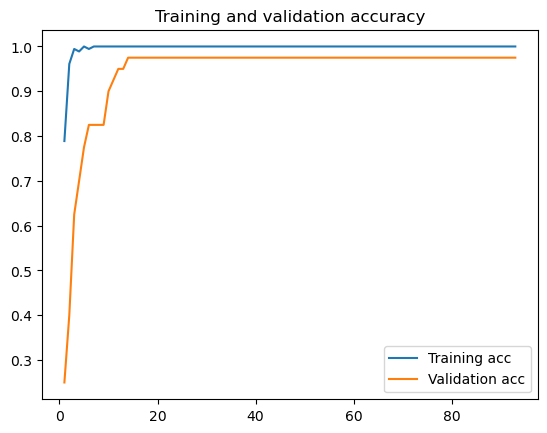

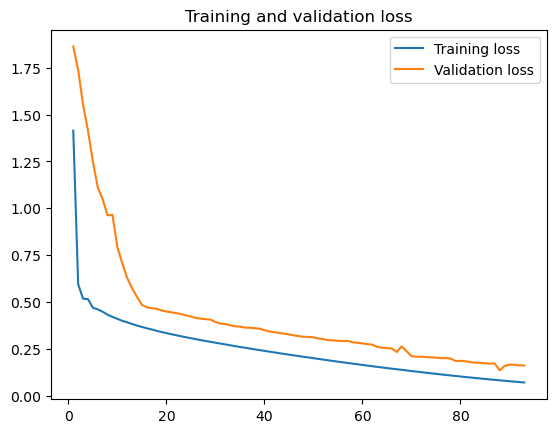

In [21]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
test_scores = model.evaluate(test_dataset, verbose=0)
print(f"Test loss: {test_scores[0]:.2f}")
print(f"Test accuracy: {test_scores[1]:.2f}")

Test loss: 0.20
Test accuracy: 0.95
